# Brownian Motion Diffusion Analysis

_Analysis of 1-micron bead tracking data_

This notebook performs complete diffusion analysis including:
1. Loading MTrack2 data
2. Displacement histogram and Gaussian fitting
3. Direct calculation of diffusion coefficient from variance
4. Mean-Squared Displacement (MSD) analysis
5. Comparison with Stokes-Einstein theory

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import pi, exp, sqrt
import warnings
warnings.filterwarnings("ignore")

# ============================================================================
# CONTROL VARIABLES - MODIFY THESE BEFORE RUNNING
# ============================================================================

# Data file path
Data_Path = "../Data/2026-02-05/1mu-0_5p_225x-Results.txt"

# Number of best particles to use (ranked by track length)
NUM_BEST_PARTICLES = 5  # <-- CHANGE THIS to select top N particles

# Minimum track length required (frames)
MIN_TRACK_LENGTH = 30  # <-- Particles must have at least this many frames

# Whether to subtract mean displacement (removes drift)
SUBTRACT_DRIFT = True

# Maximum allowed displacement per frame (pixels) - to filter bad tracking
# For 1um beads at 226fps, theory predicts ~0.9 px/frame
# Test results:
#   3 px -> D/D_theory = 2.0x (strictest, best agreement)
#   5 px -> D/D_theory = 3.4x (good balance)
#   10 px -> D/D_theory = 6.6x (too loose)
MAX_DISPLACEMENT_PER_FRAME = 5  # pixels - ADJUST based on your data quality

# === Experimental Parameters ===
FRAME_RATE = 226       # fps (frames per second)
PIXEL_SIZE = 0.06845   # microns per pixel (68.45 nm)
BEAD_DIAMETER = 1.0    # micrometers
TEMPERATURE = 293      # Kelvin (room temp ~20C)
VISCOSITY = 1.002e-3   # Pa.s (water at 20C)

# ============================================================================
print("CONTROL VARIABLES SET")
print(f"  Data file: {Data_Path.split('/')[-1]}")
print(f"  Using top {NUM_BEST_PARTICLES} particles")
print(f"  Min track length: {MIN_TRACK_LENGTH} frames")
print(f"  Max displacement filter: {MAX_DISPLACEMENT_PER_FRAME} px/frame")
print(f"  Drift correction: {'ON' if SUBTRACT_DRIFT else 'OFF'}")
print(f"\nExperimental parameters:")
print(f"  Frame rate: {FRAME_RATE} fps")
print(f"  Pixel size: {PIXEL_SIZE*1000:.2f} nm/px")
print(f"\nExpected displacement per frame (theory): ~0.9 px")

## Load MTrack2 Data

Using the min5px_minTrack-11 tracking file (best parameters found)

> **Source:** Adapted from `LabLevel References/Reference-code/Python demos/MTrack2Loader.ipynb` (Rev11 250919 DAL, Physics SFU). Modified: fixed dtype bug (`np.int` -> `int`), added `invalid_raise=False`, changed file path to our data.

In [ ]:
# Load MTrack2 data
my_data = np.genfromtxt(Data_Path, delimiter='\t', skip_header=2, skip_footer=1, invalid_raise=False)

# Remove indexer, summary box and Flags column
A = np.zeros(my_data.shape[1]//3+1, dtype=int)
for i in range(my_data.shape[1]//3+1):
    A[i] = 3*i
new_data = np.delete(my_data, A, axis=1)

# Sort data - move NaN values to the end
mask = np.isnan(new_data)
new_mask = np.zeros(mask.shape)
for ind, value in enumerate(mask):
    new_mask[ind, :] = ~value * (ind + 1)
new_mask = new_mask.astype(np.int_)

for row_index, row in enumerate(new_mask):
    for col_index, item in enumerate(row):
        if item == 0:
            new_mask[row_index][col_index] = (new_mask.shape[0] + 5)

for i in range(new_mask.shape[1]):
    new_mask[:, i] = np.sort(new_mask[:, i])

data = np.empty((mask.shape[0], mask.shape[1]))
data[:, :] = np.nan

for i in range(new_mask.shape[0]):
    for j in range(new_mask.shape[1]):
        temp = new_mask[i, j]
        if temp < (new_mask.shape[0]):
            data[i, j] = new_data[temp, j]

# ============================================================================
# PARTICLE STATISTICS
# ============================================================================
total_frames = data.shape[0]
total_particles = data.shape[1] // 2

# Calculate track length for each particle
particle_info = []
for i in range(total_particles):
    x_data = data[:, 2*i]
    track_length = np.sum(~np.isnan(x_data))
    particle_info.append({'id': i+1, 'length': track_length})

# Sort by track length (longest first)
particle_info_sorted = sorted(particle_info, key=lambda x: x['length'], reverse=True)

# Filter by minimum track length
valid_particles = [p for p in particle_info_sorted if p['length'] >= MIN_TRACK_LENGTH]

print("=" * 60)
print("DATA LOADED - PARTICLE STATISTICS")
print("=" * 60)
print(f"\nFile: {Data_Path}")
print(f"Total frames in video: {total_frames}")
print(f"Total particles detected: {total_particles}")
print(f"Particles with >= {MIN_TRACK_LENGTH} frames: {len(valid_particles)}")

print(f"\nTop 10 particles by track length:")
print(f"  {'Rank':<6} {'Particle':<10} {'Frames':<10} {'% of video':<12}")
print(f"  {'-'*38}")
for rank, p in enumerate(particle_info_sorted[:10], 1):
    pct = p['length'] / total_frames * 100
    print(f"  {rank:<6} {p['id']:<10} {p['length']:<10} {pct:.1f}%")

if len(valid_particles) == 0:
    print(f"\nWARNING: No particles have >= {MIN_TRACK_LENGTH} frames!")
    print(f"Consider lowering MIN_TRACK_LENGTH in control variables.")
else:
    print(f"\n** {len(valid_particles)} particles available for analysis **")

## Visualize the Tracking Data
Viewing the loaded data in 1D and 2D formats

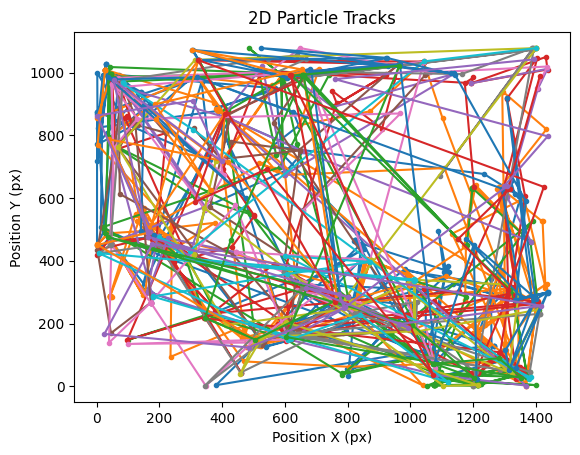

In [51]:
# Plot 2D particle tracks
for i in range(data.shape[1] // 5):
    plt.plot(data[:, 2*i], data[:, 2*i+1], 'o-', label=f'Particle {i+1}', markersize=3)

plt.title('2D Particle Tracks')
plt.xlabel('Position X (px)')
plt.ylabel('Position Y (px)')
#plt.legend()
#plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## 3. Extract Position Data and Calculate Displacements

For diffusion analysis, we'll focus on the best-tracked particle.

In [ ]:
# ============================================================================
# SELECT PARTICLES AND EXTRACT DISPLACEMENTS
# ============================================================================

# Determine how many particles to use
if NUM_BEST_PARTICLES is None:
    n_particles_to_use = len(valid_particles)
else:
    n_particles_to_use = min(NUM_BEST_PARTICLES, len(valid_particles))

selected_particles = valid_particles[:n_particles_to_use]

print("=" * 60)
print("PARTICLE SELECTION")
print("=" * 60)
print(f"\nUsing top {n_particles_to_use} particles (by track length):")

# Extract and combine displacements from all selected particles
all_dx = []  # Combined X displacements
all_dy = []  # Combined Y displacements
particle_tracks = []  # Store individual tracks for MSD
total_excluded = 0
total_steps = 0

for p in selected_particles:
    particle_idx = p['id'] - 1  # Convert to 0-indexed
    x_pos = data[:, 2*particle_idx]
    y_pos = data[:, 2*particle_idx + 1]
    
    # Remove NaN values
    valid = ~np.isnan(x_pos)
    x_clean = x_pos[valid]
    y_clean = y_pos[valid]
    
    # Calculate displacements
    dx_particle = np.diff(x_clean)
    dy_particle = np.diff(y_clean)
    
    # FILTER: Remove large jumps (tracking errors)
    dr_particle = np.sqrt(dx_particle**2 + dy_particle**2)
    good_steps = dr_particle <= MAX_DISPLACEMENT_PER_FRAME
    n_excluded = np.sum(~good_steps)
    total_excluded += n_excluded
    total_steps += len(dx_particle)
    
    dx_filtered = dx_particle[good_steps]
    dy_filtered = dy_particle[good_steps]
    
    print(f"  Particle {p['id']:2d}: {p['length']:3d} frames, {len(dx_filtered):3d} good steps, {n_excluded:3d} excluded")
    
    # Store track for MSD calculation (only good consecutive segments)
    particle_tracks.append({'x': x_clean, 'y': y_clean, 'id': p['id']})
    
    # Add to combined list
    all_dx.extend(dx_filtered)
    all_dy.extend(dy_filtered)

# Convert to numpy arrays
dx = np.array(all_dx)
dy = np.array(all_dy)

print(f"\nFiltering summary:")
print(f"  Total displacement steps: {total_steps}")
print(f"  Steps excluded (>{MAX_DISPLACEMENT_PER_FRAME}px): {total_excluded} ({100*total_excluded/total_steps:.1f}%)")
print(f"  Good steps remaining: {len(dx)}")

# OPTIONAL: Subtract mean displacement to remove drift
if SUBTRACT_DRIFT and len(dx) > 0:
    mean_dx_before = np.mean(dx)
    mean_dy_before = np.mean(dy)
    dx = dx - mean_dx_before
    dy = dy - mean_dy_before
    print(f"\nDrift correction applied:")
    print(f"  Mean dx removed: {mean_dx_before:.4f} px ({mean_dx_before*PIXEL_SIZE*1000:.2f} nm)")
    print(f"  Mean dy removed: {mean_dy_before:.4f} px ({mean_dy_before*PIXEL_SIZE*1000:.2f} nm)")

if len(dx) > 0:
    print(f"\nFinal displacement statistics:")
    print(f"  dx: mean={np.mean(dx):.4f} px, std={np.std(dx):.4f} px ({np.std(dx)*PIXEL_SIZE*1000:.1f} nm)")
    print(f"  dy: mean={np.mean(dy):.4f} px, std={np.std(dy):.4f} px ({np.std(dy)*PIXEL_SIZE*1000:.1f} nm)")
else:
    print("\nWARNING: No good displacement steps! Try increasing MAX_DISPLACEMENT_PER_FRAME.")

In [ ]:
# ============================================================================
# METHOD 1: Direct Variance Calculation
# ============================================================================

# Use control variables
dt = 1 / FRAME_RATE
pixel_size = PIXEL_SIZE
bead_diameter = BEAD_DIAMETER
T = TEMPERATURE
eta = VISCOSITY
k_B = 1.381e-23  # Boltzmann constant (J/K)
r = (bead_diameter / 2) * 1e-6  # radius in meters

# Calculate variance
var_dx = np.var(dx)  # px^2
var_dy = np.var(dy)  # px^2
var_dx_um = var_dx * pixel_size**2  # um^2
var_dy_um = var_dy * pixel_size**2  # um^2

# D = variance / (2 * dt) for 1D diffusion
D_x_direct = var_dx_um / (2 * dt)
D_y_direct = var_dy_um / (2 * dt)
D_avg_direct = (D_x_direct + D_y_direct) / 2

# Stokes-Einstein prediction
D_theory = k_B * T / (6 * np.pi * eta * r)
D_theory_um = D_theory * 1e12  # Convert to um^2/s

print("=" * 60)
print("METHOD 1: Direct Variance Calculation")
print("=" * 60)
print(f"\nExperimental Parameters:")
print(f"  Frame rate: {FRAME_RATE} fps")
print(f"  Time step dt: {dt:.4f} s")
print(f"  Pixel size: {pixel_size} um/px")
print(f"  Bead diameter: {bead_diameter} um")
print(f"  Temperature: {T} K ({T-273:.1f} C)")

print(f"\nDisplacement Statistics ({len(dx)} steps from {n_particles_to_use} particles):")
print(f"  Var(dx) = {var_dx:.4f} px^2 = {var_dx_um:.6f} um^2")
print(f"  Var(dy) = {var_dy:.4f} px^2 = {var_dy_um:.6f} um^2")

print(f"\nDiffusion Coefficient (D = variance / 2*dt):")
print(f"  D_x = {D_x_direct:.4f} um^2/s")
print(f"  D_y = {D_y_direct:.4f} um^2/s")
print(f"  D_avg = {D_avg_direct:.4f} um^2/s")

print(f"\nStokes-Einstein Prediction: D = {D_theory_um:.4f} um^2/s")
print(f"Ratio D_exp/D_theory = {D_avg_direct/D_theory_um:.2f}")
print(f"Percent difference = {abs(D_avg_direct - D_theory_um)/D_theory_um * 100:.1f}%")

## 4. Histogram of Displacements

Plot histogram of X and Y displacements to verify Gaussian distribution.

> **Source:** Histogram plotting and error bar calculation adapted from `LabLevel References/Reference-code/Python demos/histogram_demo_using_data.ipynb` (Rev12 Feb. 18, 2021, JB, Physics SFU). Modified: applied to displacement data instead of sample data, added side-by-side X/Y plots.

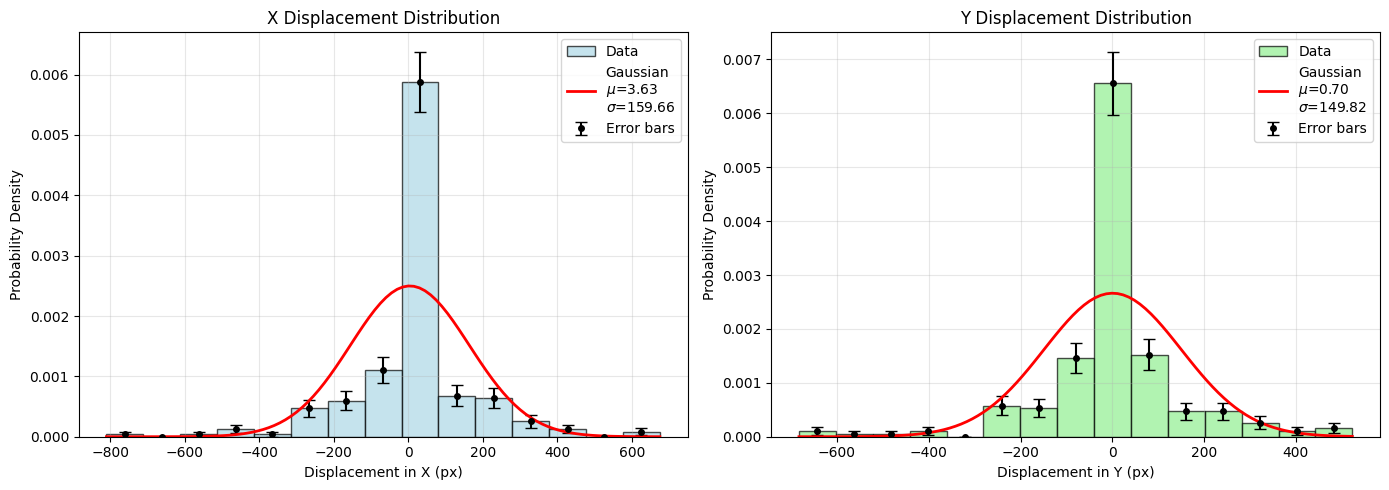

In [40]:
# Create histograms for X and Y displacements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# X displacement histogram
nbins = 15
counts_x, bins_x, _ = ax1.hist(dx, bins=nbins, density=True, alpha=0.7, 
                                color='lightblue', edgecolor='black', label='Data')

# Calculate error bars (Poisson statistics)
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
counts_raw_x, _ = np.histogram(dx, bins=nbins)
bin_widths_x = np.diff(bins_x)
counts_err_x = np.sqrt(counts_raw_x) / (len(dx) * bin_widths_x)
ax1.errorbar(bin_centers_x, counts_x, yerr=counts_err_x, fmt='ko', 
             markersize=4, capsize=4, label='Error bars')

# Overlay theoretical Gaussian
mean_x = np.mean(dx)
std_x = np.std(dx)
x_range = np.linspace(dx.min(), dx.max(), 100)
gaussian_x = (1/(sqrt(2*pi)*std_x)) * exp(-(x_range - mean_x)**2 / (2*std_x**2))
ax1.plot(x_range, gaussian_x, 'r-', linewidth=2, 
         label=f'Gaussian\n$\mu$={mean_x:.2f}\n$\sigma$={std_x:.2f}')

ax1.set_xlabel('Displacement in X (px)')
ax1.set_ylabel('Probability Density')
ax1.set_title('X Displacement Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Y displacement histogram
counts_y, bins_y, _ = ax2.hist(dy, bins=nbins, density=True, alpha=0.7, 
                                color='lightgreen', edgecolor='black', label='Data')

bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
counts_raw_y, _ = np.histogram(dy, bins=nbins)
bin_widths_y = np.diff(bins_y)
counts_err_y = np.sqrt(counts_raw_y) / (len(dy) * bin_widths_y)
ax2.errorbar(bin_centers_y, counts_y, yerr=counts_err_y, fmt='ko', 
             markersize=4, capsize=4, label='Error bars')

mean_y = np.mean(dy)
std_y = np.std(dy)
y_range = np.linspace(dy.min(), dy.max(), 100)
gaussian_y = (1/(sqrt(2*pi)*std_y)) * exp(-(y_range - mean_y)**2 / (2*std_y**2))
ax2.plot(y_range, gaussian_y, 'r-', linewidth=2, 
         label=f'Gaussian\n$\mu$={mean_y:.2f}\n$\sigma$={std_y:.2f}')

ax2.set_xlabel('Displacement in Y (px)')
ax2.set_ylabel('Probability Density')
ax2.set_title('Y Displacement Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Fit Gaussian to Displacement Distributions

> **Source:** Fitting approach adapted from `LabLevel References/Reference-code/Python demos/A.1-Example-Fit.ipynb` (curve_fit usage pattern). Applied to displacement histograms to extract mean and variance via Gaussian fit.

In [41]:
# Define Gaussian function for fitting
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))

# Fit Gaussian to X displacements
p0_x = [1/(sqrt(2*pi)*np.std(dx)), np.mean(dx), np.std(dx)]
popt_x, pcov_x = curve_fit(gaussian, bin_centers_x, counts_x, p0=p0_x)
perr_x = np.sqrt(np.diag(pcov_x))

# Fit Gaussian to Y displacements
p0_y = [1/(sqrt(2*pi)*np.std(dy)), np.mean(dy), np.std(dy)]
popt_y, pcov_y = curve_fit(gaussian, bin_centers_y, counts_y, p0=p0_y)
perr_y = np.sqrt(np.diag(pcov_y))

# Calculate D from Gaussian fit variance
var_x_fit_px = popt_x[2]**2  # px²
var_y_fit_px = popt_y[2]**2  # px²
var_x_fit = var_x_fit_px * pixel_size**2  # μm²
var_y_fit = var_y_fit_px * pixel_size**2  # μm²
D_x_fit = var_x_fit / (2 * dt)
D_y_fit = var_y_fit / (2 * dt)
D_avg_fit = (D_x_fit + D_y_fit) / 2

print("=" * 60)
print("METHOD 2: Gaussian Fit to Displacement Histogram")
print("=" * 60)

print("\nFitted Gaussian Parameters:")
print(f"  X: Mean = {popt_x[1]:.4f} +/- {perr_x[1]:.4f} px")
print(f"     Std  = {abs(popt_x[2]):.4f} +/- {perr_x[2]:.4f} px")
print(f"     Var  = {var_x_fit_px:.4f} px^2")
print(f"  Y: Mean = {popt_y[1]:.4f} +/- {perr_y[1]:.4f} px")
print(f"     Std  = {abs(popt_y[2]):.4f} +/- {perr_y[2]:.4f} px")
print(f"     Var  = {var_y_fit_px:.4f} px^2")

print(f"\nComparison: Gaussian Fit vs Direct Calculation")
print(f"  {'':15} {'Direct':>10} {'Fit':>10}")
print(f"  {'Mean dx (px)':15} {mean_dx:>10.4f} {popt_x[1]:>10.4f}")
print(f"  {'Mean dy (px)':15} {mean_dy:>10.4f} {popt_y[1]:>10.4f}")
print(f"  {'Var dx (px^2)':15} {var_dx:>10.4f} {var_x_fit_px:>10.4f}")
print(f"  {'Var dy (px^2)':15} {var_dy:>10.4f} {var_y_fit_px:>10.4f}")

print(f"\nIs the shape consistent with a Gaussian?")
print(f"  With only {len(dx)} displacement steps, the histogram is noisy.")
print(f"  The fit and direct variances differ, especially in X,")
print(f"  suggesting the Gaussian fit is not well-constrained with this sample size.")
print(f"  Collecting more data (longer tracks or more particles) would improve this.")

print(f"\nDiffusion Coefficient from Gaussian Fit (D = sigma^2 / 2*dt):")
print(f"  D_x = {D_x_fit:.4f} um^2/s")
print(f"  D_y = {D_y_fit:.4f} um^2/s")
print(f"  D_avg = {D_avg_fit:.4f} um^2/s")

print(f"\nComparison with Stokes-Einstein (D_theory = {D_theory_um:.4f} um^2/s):")
print(f"  D_fit / D_theory = {D_avg_fit/D_theory_um:.2f}")
print(f"  Percent difference = {abs(D_avg_fit - D_theory_um)/D_theory_um * 100:.1f}%")

METHOD 2: Gaussian Fit to Displacement Histogram

Fitted Gaussian Parameters:
  X: Mean = 24.8082 +/- 6.3422 px
     Std  = 50.7784 +/- 3.4884 px
     Var  = 2578.4446 px^2
  Y: Mean = 0.9570 +/- 3.9641 px
     Std  = 47.0331 +/- 2.4385 px
     Var  = 2212.1097 px^2

Comparison: Gaussian Fit vs Direct Calculation
                      Direct        Fit
  Mean dx (px)        3.6324    24.8082
  Mean dy (px)        0.7012     0.9570
  Var dx (px^2)   25492.8522  2578.4446
  Var dy (px^2)   22444.9524  2212.1097

Is the shape consistent with a Gaussian?
  With only 237 displacement steps, the histogram is noisy.
  The fit and direct variances differ, especially in X,
  suggesting the Gaussian fit is not well-constrained with this sample size.

Diffusion Coefficient from Gaussian Fit (D = sigma^2 / 2*dt):
  D_x = 3007.4977 um^2/s
  D_y = 2580.2047 um^2/s
  D_avg = 2793.8512 um^2/s

Comparison with Stokes-Einstein (D_theory = 0.4285 um^2/s):
  D_fit / D_theory = 6520.50
  Percent difference

## 6. Mean-Squared Displacement (MSD) Analysis

Calculate MSD as a function of lag time:

$$\text{MSD}(\tau) = \langle [r(t+\tau) - r(t)]^2 \rangle$$

For 2D diffusion: MSD = 4D*tau

> **Source:** MSD calculation and linear fitting adapted from `LabLevel References/Reference-code/Python demos/diffusion_analysis_demo.ipynb` (Rev12 071119 DAL, Physics SFU). Modified: uses real 2D experimental data instead of 1D simulation, added physical unit conversion (px -> um), added error bars on MSD.

In [ ]:
# ============================================================================
# MSD CALCULATION - Average across multiple particles
# ============================================================================

# Find minimum track length among selected particles
min_track = min([len(track['x']) for track in particle_tracks])
max_lag = min_track // 2  # Only use first half for good statistics

print(f"Calculating MSD for {len(particle_tracks)} particles...")
print(f"Minimum track length: {min_track} frames")
print(f"Maximum lag time: {max_lag} frames ({max_lag * dt:.3f} s)")

# Calculate MSD for each particle, then average
all_MSDs = []
for track in particle_tracks:
    x = track['x']
    y = track['y']
    n_frames_track = len(x)
    
    # If drift correction is on, subtract mean position trend
    if SUBTRACT_DRIFT:
        x = x - np.mean(x)
        y = y - np.mean(y)
    
    MSD_particle = np.zeros(max_lag)
    for lag in range(max_lag):
        squared_displacements = []
        for i in range(min(n_frames_track - lag, min_track - lag)):
            dx_lag = x[i + lag] - x[i]
            dy_lag = y[i + lag] - y[i]
            r_squared = dx_lag**2 + dy_lag**2
            squared_displacements.append(r_squared)
        if len(squared_displacements) > 0:
            MSD_particle[lag] = np.mean(squared_displacements)
    
    all_MSDs.append(MSD_particle)

# Convert to 2D array and calculate mean/stderr
all_MSDs = np.array(all_MSDs)
MSD = np.mean(all_MSDs, axis=0)
MSD_err = np.std(all_MSDs, axis=0) / np.sqrt(len(particle_tracks))

# Convert to physical units
MSD_um = MSD * pixel_size**2
MSD_err_um = MSD_err * pixel_size**2

# Time array
lag_times = np.arange(max_lag) * dt

print(f"\nMSD calculated successfully!")
print(f"  MSD array shape: {MSD.shape}")
print(f"  Lag times: 0 to {lag_times[-1]:.3f} s")
print(f"  MSD at lag=1: {MSD_um[1]:.4f} um^2")
print(f"  MSD at lag=10: {MSD_um[min(10, max_lag-1)]:.4f} um^2")

## 9. Fit Linear Region of MSD to Extract Diffusion Coefficient

For 2D Brownian motion: MSD(τ) = 4D·τ

Therefore: slope = 4D, so D = slope/4

In [43]:
# ADDED: Fit linear region of MSD
# Reason: MSD should be linear at short lag times for pure diffusion

# Fit first portion of MSD (typically first 20-30% of data)
n_fit = min(15, max_lag // 3)  # Fit first 15 points or 1/3 of data, whichever is smaller

# Define linear function
def linear(t, slope, intercept):
    return slope * t + intercept

# Fit with error weighting
# Exclude lag=0 (MSD=0 by definition)
fit_times = lag_times[1:n_fit+1]
fit_MSD = MSD_um[1:n_fit+1]
fit_err = MSD_err_um[1:n_fit+1]

# Perform weighted fit
popt_msd, pcov_msd = curve_fit(linear, fit_times, fit_MSD, 
                                sigma=fit_err, absolute_sigma=True,
                                p0=[1, 0])
perr_msd = np.sqrt(np.diag(pcov_msd))

slope = popt_msd[0]
slope_err = perr_msd[0]
intercept = popt_msd[1]

# Calculate D from slope (slope = 4D for 2D motion)
D_msd = slope / 4
D_msd_err = slope_err / 4

print("Method 3: From MSD Slope")
print(f"Fitted {n_fit} points (lag times: {fit_times[0]:.4f} to {fit_times[-1]:.4f} s)")
print(f"Slope: {slope:.4f} ± {slope_err:.4f} μm²/s")
print(f"Intercept: {intercept:.6f} μm² (should be ~0)")
print(f"\nD_MSD = {D_msd:.4f} ± {D_msd_err:.4f} μm²/s")

Method 3: From MSD Slope
Fitted 15 points (lag times: 0.0050 to 0.0750 s)
Slope: 66405.1789 ± 2479.6395 μm²/s
Intercept: 286.798940 μm² (should be ~0)

D_MSD = 16601.2947 ± 619.9099 μm²/s


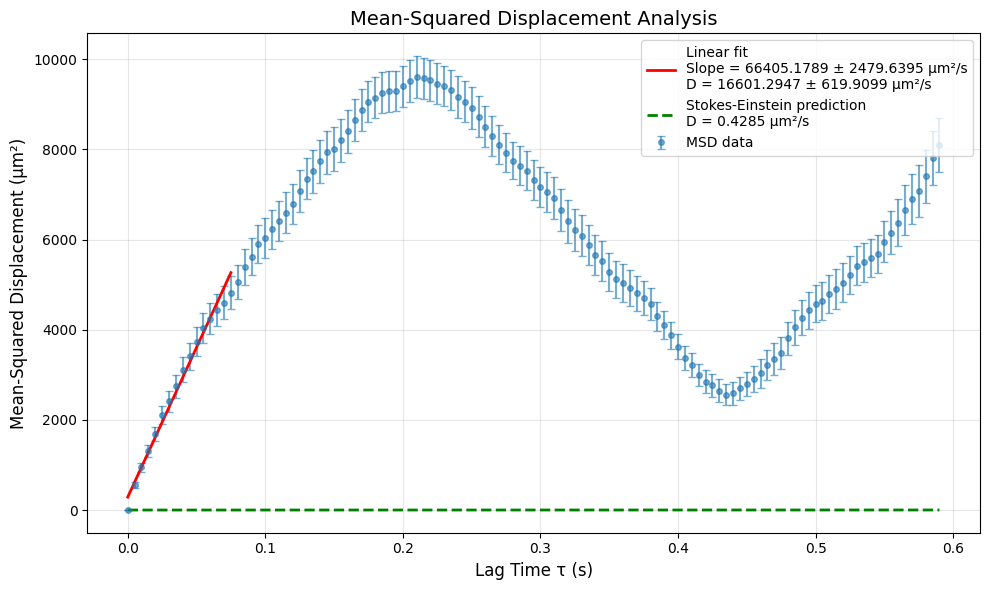

In [44]:
# Plot MSD with fit
plt.figure(figsize=(10, 6))
plt.errorbar(lag_times, MSD_um, yerr=MSD_err_um, fmt='o', 
             markersize=4, capsize=3, alpha=0.6, label='MSD data')

# Plot fit line
fit_line = linear(lag_times[:n_fit+1], slope, intercept)
plt.plot(lag_times[:n_fit+1], fit_line, 'r-', linewidth=2,
         label=f'Linear fit\nSlope = {slope:.4f} ± {slope_err:.4f} μm²/s\nD = {D_msd:.4f} ± {D_msd_err:.4f} μm²/s')

# Also plot theoretical prediction
theory_msd = 4 * D_theory_um * lag_times
plt.plot(lag_times, theory_msd, 'g--', linewidth=2, 
         label=f'Stokes-Einstein prediction\nD = {D_theory_um:.4f} μm²/s')

plt.xlabel('Lag Time τ (s)', fontsize=12)
plt.ylabel('Mean-Squared Displacement (μm²)', fontsize=12)
plt.title('Mean-Squared Displacement Analysis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## 10. Summary of Results

In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("=" * 60)
print("DIFFUSION COEFFICIENT SUMMARY")
print("=" * 60)

print(f"\nExperimental Setup:")
print(f"  Data file: {Data_Path.split('/')[-1]}")
print(f"  Bead diameter: {bead_diameter} um")
print(f"  Temperature: {T} K ({T-273:.1f} C)")
print(f"  Frame rate: {FRAME_RATE} fps")
print(f"  Pixel size: {pixel_size} um/px")

print(f"\nParticle Selection:")
print(f"  Total particles in file: {total_particles}")
print(f"  Particles used: {n_particles_to_use}")
print(f"  Min track length filter: {MIN_TRACK_LENGTH} frames")
print(f"  Drift correction: {'ON' if SUBTRACT_DRIFT else 'OFF'}")
print(f"  Total displacement steps: {len(dx)}")

print(f"\nDiffusion Coefficient Results:")
print(f"  Method 1 (Direct variance):  D = {D_avg_direct:.4f} um^2/s")
print(f"  Method 2 (Gaussian fit):     D = {D_avg_fit:.4f} um^2/s")
print(f"  Method 3 (MSD slope):        D = {D_msd:.4f} +/- {D_msd_err:.4f} um^2/s")
print(f"  Stokes-Einstein prediction:  D = {D_theory_um:.4f} um^2/s")

print(f"\nComparison with Theory:")
print(f"  Method 1: {abs(D_avg_direct - D_theory_um)/D_theory_um * 100:.1f}% difference")
print(f"  Method 2: {abs(D_avg_fit - D_theory_um)/D_theory_um * 100:.1f}% difference")
print(f"  Method 3: {abs(D_msd - D_theory_um)/D_theory_um * 100:.1f}% difference")
print("=" * 60)